In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HealthCare/hungary_chickenpox.csv')
df_main.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [4]:
df_main.shape

(522, 21)

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      522 non-null    object
 1   BUDAPEST  522 non-null    int64 
 2   BARANYA   522 non-null    int64 
 3   BACS      522 non-null    int64 
 4   BEKES     522 non-null    int64 
 5   BORSOD    522 non-null    int64 
 6   CSONGRAD  522 non-null    int64 
 7   FEJER     522 non-null    int64 
 8   GYOR      522 non-null    int64 
 9   HAJDU     522 non-null    int64 
 10  HEVES     522 non-null    int64 
 11  JASZ      522 non-null    int64 
 12  KOMAROM   522 non-null    int64 
 13  NOGRAD    522 non-null    int64 
 14  PEST      522 non-null    int64 
 15  SOMOGY    522 non-null    int64 
 16  SZABOLCS  522 non-null    int64 
 17  TOLNA     522 non-null    int64 
 18  VAS       522 non-null    int64 
 19  VESZPREM  522 non-null    int64 
 20  ZALA      522 non-null    int64 
dtypes: int64(20), ob

In [6]:
df = df_main[['Date','BUDAPEST']]
df = df[df['BUDAPEST'] > 0]
df.reset_index(inplace=True,drop=True)

In [7]:
time = pd.date_range(start='1/3/2005',periods=521,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [8]:
df.min()

BUDAPEST    2
dtype: int64

In [9]:
df.head()

,BUDAPEST
time_stamp,
2005-01-09,168
2005-01-16,157
2005-01-23,96
2005-01-30,163
2005-02-06,122


In [10]:
df.tail()

,BUDAPEST
time_stamp,
2014-11-30,95
2014-12-07,43
2014-12-14,35
2014-12-21,30
2014-12-28,259


In [32]:
plt.rcParams['figure.figsize'] = [15,8]

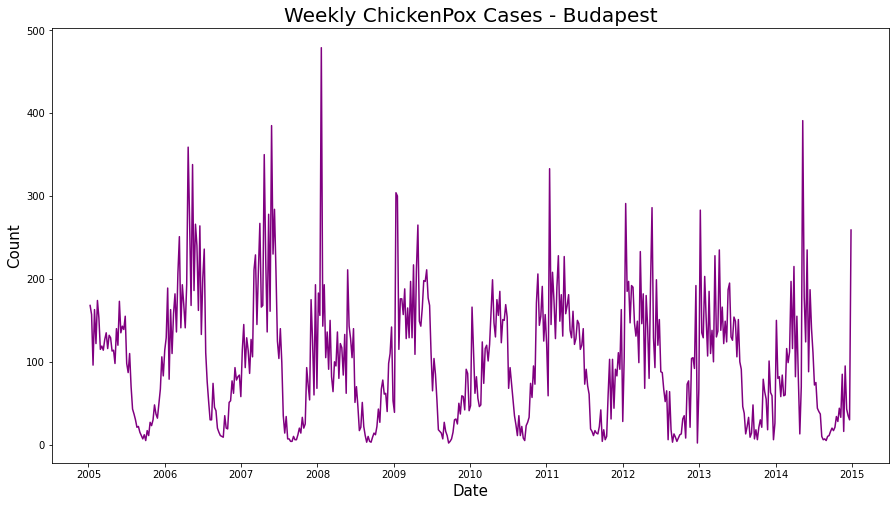

In [12]:
plt.plot(df,color='purple')
plt.title('Weekly ChickenPox Cases - Budapest',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [13]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [34]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['BUDAPEST'] = df['BUDAPEST'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [35]:
#Split data set into testing dataset and train dataset
train_size = 469
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 3
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(466, 1, 3)
(466,)
(49, 1, 3)
(49,)


In [16]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 27.9 MB/s 


In [18]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('rnn_layer_1',min_value=16,max_value=256,step=16), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    for i in range(hp.Int('n_layers', 1, 6)):
        model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=16,max_value=256,step=16),activation="relu", return_sequences=True,recurrent_dropout = hp.Choice(f"recurrent_dropout_{i}",[0.2,0.4,0.6],default=0.4)))
    model.add(SimpleRNN(hp.Int('final_rnn_layer',min_value=16,max_value=256,step=16),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(Dense(hp.Int(f'rnn_{i}_units',min_value=16,max_value=256,step=16),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_5')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
rnn_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
recurrent_dropout_0 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{

In [ ]:
tuner.search(trainX, trainY,
             epochs=500,
             batch_size=36,
             validation_data=(testX, testY))

Trial 10 Complete [00h 01m 34s]
val_mae: 0.06589418649673462

Best val_mae So Far: 0.06503663957118988
Total elapsed time: 00h 17m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_5
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
rnn_layer_1: 208
first_recurrent_dropout: 0.4
n_layers: 5
rnn_0_units: 32
recurrent_dropout_0: 0.6
final_rnn_layer: 160
last_recurrent_dropout: 0.4
Dropout_rate: 0.0
learning_rate: 0.0008474710422162923
rnn_1_units: 64
recurrent_dropout_1: 0.2
rnn_2_units: 32
recurrent_dropout_2: 0.6
rnn_3_units: 240
recurrent_dropout_3: 0.6
rnn_4_units: 144
recurrent_dropout_4: 0.2
rnn_5_units: 160
recurrent_dropout_5: 0.6
Score: 0.06503663957118988
Trial summary
Hyperparameters:
rnn_layer_1: 208
first_recurrent_dropout: 0.2
n_layers: 4
rnn_0_units: 208
recurrent_dropout_0: 0.2
final_rnn_layer: 176
last_recurrent_dropout: 0.4
Dropout_rate: 0.5
learning_rate: 0.0013162306201721225
rnn_1_units: 176
recurrent_dropout_1: 0.4
rnn_2_units: 16
recurrent_dropout_2: 0.6
rnn_3_units: 192
recurrent_dropout_3: 0.2
rnn_4_units: 80
recurrent_dropout_4: 0.2
rnn_5_units: 160
rec

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 208)            44096     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 32)             7712      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 64)             6208      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1, 32)             3104      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 1, 240)            65520     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 1, 144)            55440     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 160)               4

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [38]:
model = Sequential()
model.add(SimpleRNN(512,activation='relu',input_dim = 3,return_sequences=True))
model.add(SimpleRNN(256,activation='relu',return_sequences=True))
model.add(SimpleRNN(128,activation='relu',return_sequences=True))
model.add(SimpleRNN(64,activation='relu',return_sequences=True))
model.add(SimpleRNN(32,activation='relu',return_sequences=True))
model.add(SimpleRNN(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00001474710422162923)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 700)

Epoch 1/700
13/13 [==============================] - 7s 76ms/step - loss: 0.2923 - mae: 0.2923 - val_loss: 0.2510 - val_mae: 0.2510
Epoch 2/700
13/13 [==============================] - 0s 16ms/step - loss: 0.2871 - mae: 0.2871 - val_loss: 0.2476 - val_mae: 0.2476
Epoch 3/700
13/13 [==============================] - 0s 18ms/step - loss: 0.2833 - mae: 0.2833 - val_loss: 0.2439 - val_mae: 0.2439
Epoch 4/700
13/13 [==============================] - 0s 16ms/step - loss: 0.2790 - mae: 0.2790 - val_loss: 0.2399 - val_mae: 0.2399
Epoch 5/700
13/13 [==============================] - 0s 16ms/step - loss: 0.2750 - mae: 0.2750 - val_loss: 0.2355 - val_mae: 0.2355
Epoch 6/700
13/13 [==============================] - 0s 15ms/step - loss: 0.2694 - mae: 0.2694 - val_loss: 0.2301 - val_mae: 0.2301
Epoch 7/700
13/13 [==============================] - 0s 15ms/step - loss: 0.2624 - mae: 0.2624 - val_loss: 0.2238 - val_mae: 0.2238
Epoch 8/700
13/13 [==============================] - 0s 17ms/step - loss: 0.

In [22]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [23]:
trainX_2 = scaler.inverse_transform(trainX.reshape(-1,3))
trainY_2 = scaler.inverse_transform([trainY])
testX_2 = scaler.inverse_transform(testX.reshape(-1,3))
testY_2 = scaler.inverse_transform([testY])
train_score_2 = model.evaluate(trainX_2.reshape(-1,1,3), trainY_2.reshape(-1,),verbose=0)
test_score_2 = model.evaluate(testX_2.reshape(-1,1,3), testY_2.reshape(-1,),verbose=0)

Train MAE: 31.918874731303376
Test MAE: 36.82495274066413


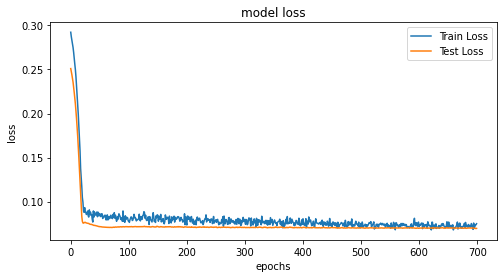

In [39]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print("Train MAE:",mae(trainY.reshape(-1,),train_predict.reshape(-1,)))
print("Test MAE:",mae(testY.reshape(-1,),test_predict.reshape(-1,)))
model_loss(model_history)

In [27]:
import seaborn as sns

In [30]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(466,515)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

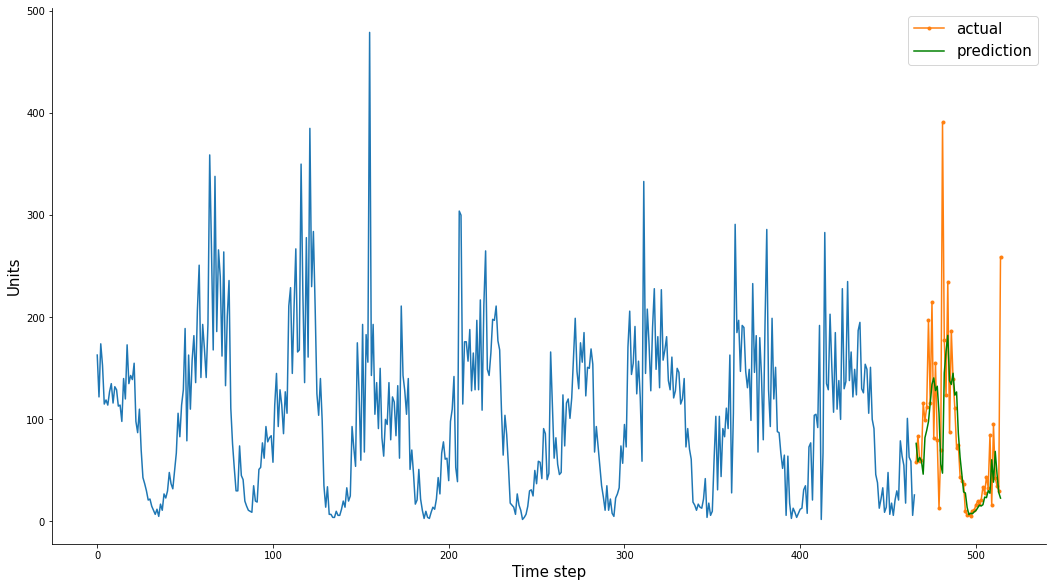

In [40]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)